**Chiara Piccolo - Assignment 1**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import itertools
from statsmodels.tsa.stattools import ccf


data = pd.read_csv('https://raw.githubusercontent.com/cpic29/ISPR/main/AirQualityUCI.csv', delimiter=';', nrows=9357)

df = data.drop(['NMHC(GT)', 'Unnamed: 15', 'Unnamed: 16'], axis=1, inplace=False)

**1. Preparing the data**

In preparing the dataset for the analysis, the first step was to handle missing values, represented by NaNs, as suggested by the assignment instructions. When a NaN value was found between two numerical values, it was replaced with the mean of the immediately preceding and following numerical values. If the NaN was not surrounded by numerical values on both sides, I chose to replace it with the data corresponding to the same hour of the previous day. Afterward, the data was standardized. This transformation was applied to ensure that all time series had a common scale, allowing for meaningful comparisons between variables that originally had different units of measurement.

In [ ]:
#Element conversion from object to int
columns_to_convert = ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH']
for column in columns_to_convert:
    df[column] = df[column].str.replace(',', '.')
    df[column] = pd.to_numeric(df[column], errors='coerce')

#Unification of Date and Time columns in an only column to facilitate following computations
date_time_format = '%d/%m/%Y %H.%M.%S'
df['DT'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format=date_time_format)
df['Date'] = df['DT']
df.drop(['Time', 'DT'], axis=1, inplace=True)
df.rename(columns={'Date': 'Datetime'}, inplace=True)

#Missing data (-200) are transformed in a NaN form
for column in df.columns:
    if column != 'Datetime':
        df[column] = df[column].replace(-200, np.nan)

#Interpolation: Nan values that are not in a long sequence (limit=1) become the average of the following and previous results
cols_to_interpolate = df.columns.difference(['Datetime'])
df[cols_to_interpolate] = df[cols_to_interpolate].interpolate(limit=1)

#The remaining NaN values take the value of the misuration 24h before
for col_name, col_data in df.items():
    if col_name != 'Datetime':
        nan_indices = np.where(df[col_name].isna())[0]
        for index in nan_indices:
            prev_time = df.loc[index, 'Datetime'] - pd.Timedelta(hours=24)
            prev_value = df.loc[df['Datetime'] == prev_time, col_name].values
            df.loc[index, col_name] = prev_value[0]

In [ ]:
#Data normalization
df.set_index('Datetime', inplace=True)
col_to_normalize= df.columns.difference(['Datetime'])
avg_col = df[col_to_normalize].mean()
std_col = df[col_to_normalize].std()
df_normalized = df[col_to_normalize].sub(avg_col, axis=1).div(std_col, axis=1)
df_normalized.reset_index(inplace=True)
df_normalized.set_index('Datetime', inplace=True)

**2. Cross-correlation calculations**



The next step was to create a function that would calculate the normalized cross-correlation using the formula explained in class. After that, the cross correlation between each pair of sensors was plotted.

In [ ]:
def ccf(x, y):
    autocov_x = np.sum((x)**2)
    autocov_y = np.sum((y)**2)

    #Cross-correlation
    ccf = np.correlate(x, y, 'full')

    #Cross-correlation normalization
    ccf /= np.sqrt(autocov_x * autocov_y)

    return ccf

def plot_ccf(lag_range, ccf_output, col_name_a, col_name_b):
    #Plot the cross-correlation function between two columns
    plt.figure(figsize=(50, 5))
    plt.plot(lag_range, ccf_output, linewidth=0.5)
    plt.xlabel('Lag')
    plt.ylabel('Cross-Correlation')
    plt.title(f'Cross Correlation between {col_name_a} and {col_name_b}')
    plt.grid(True)
    plt.show()
    print()

def compute_and_plot_ccf_for_dataframe(df):
    columns = df.columns
    ccf_matrix = pd.DataFrame(index=columns, columns=columns)
    for col_a, col_b in itertools.combinations(df.columns, 2):
        series_a = df[col_a]
        series_b = df[col_b]
        ccf_output = ccf(series_a, series_b)
        lag_range = np.arange(-len(series_a) + 1, len(series_a))

        ccf_value = ccf_output[len(series_a)-1]
        ccf_matrix.loc[col_a, col_b] = ccf_value
        ccf_matrix.loc[col_b, col_a] = ccf_value

        #Plot the cross-correlation
        plot_ccf(lag_range, ccf_output, col_a, col_b)

    #Diagonal filled with 1s: cross-correlation of a series with itself
    np.fill_diagonal(ccf_matrix.values, 1)
    return ccf_matrix.astype(float)

def plot_ccf_heatmap(ccf_matrix):
    plt.figure(figsize=(10, 8))
    sns.heatmap(ccf_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Cross-Correlation at Lag 0 Heatmap')
    plt.show()


ccf_matrix = compute_and_plot_ccf_for_dataframe(df_normalized)

**3. Results**

Moving on to the analysis of the results, several characteristics can be found in different charts.

It can be observed that often the values of cross-correlation tend to decrease as one moves away from the central point, that is the zero lag. This trend could be related to the method of calculating cross-correlation, which uses the addition of zero values (zero-padding) at the ends of the signals. When evaluating the cross-correlation for very low or very high lags, the actual overlap between the signals decreases, and more zero values are included in the calculation. This can lead to a lower sum of point-by-point multiplications. This behavior suggests that as the lag increases, the intensity of the calculated cross-correlation tends to decrease, due to the lesser overlap between the original series.

Another interesting feature concerns the presence of multiple and regular peaks, approximately every 24 hours, which seems to indicate a daily cyclical component in the two time series. This could be the result of factors or activities that occur every day, influencing the measured values.

One example is given by the cross-correlation plot between the sensors PT08.S2 and PT08.S3.The cross-correlation graph displays a peak at zero lag, indicating a strong immediate relationship between the two variables. Periodic peaks imply a daily cycle, and the cross-correlation diminishes as we move further from the zero lag, showing a decreasing relationship over time.

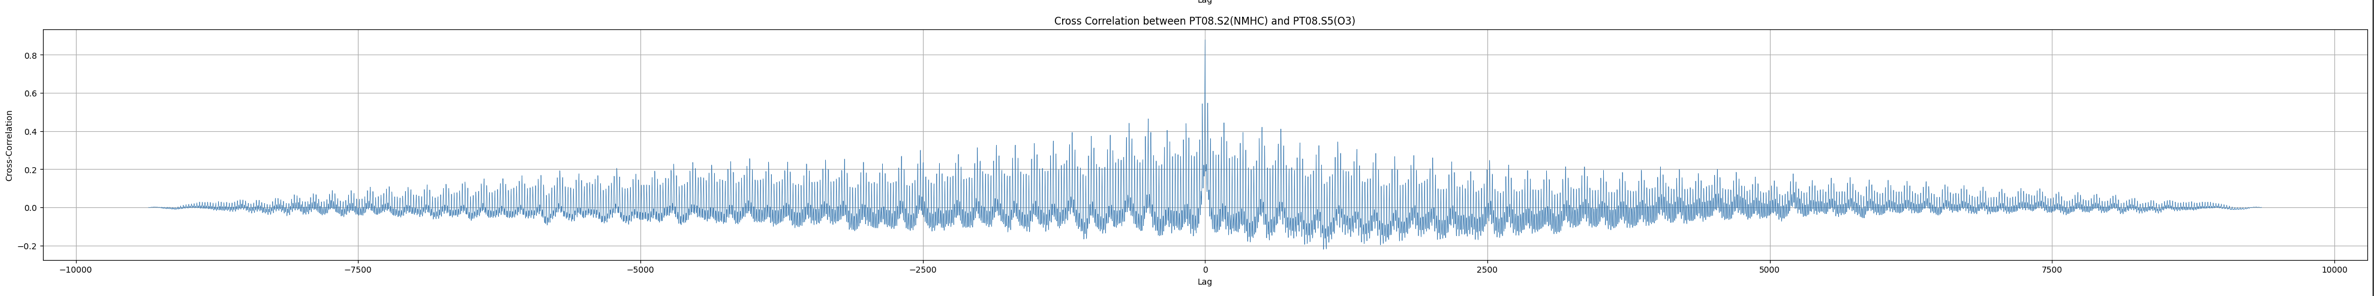







Another remarkable detail in the analysis of cross-correlation graphs concerns their symmetry. Finding symmetric cross-correlation graphs with respect to zero lag suggests a mutual influence between two variables without a clear direction of cause and effect. This symmetry could mean that variations in one variable tend to be accompanied by similar variations in the other, whether looking forward or backward in time.

As an example, we can consider the cross-correlation graph between temperature and absolute humidity. We observe a peak in cross-correlation at zero lag, followed by a largely symmetric decrease on both sides (sligth deviations are present). This highlights how temperature and humidity influence each other: higher temperatures increase moisture in the air, and more moisture traps more heat close to the ground's surface, like a blanket, which leads to more warming. This interaction shows not only a strong connection between the two variables but also the absence of a unique cause-and-effect relationship, reflecting a dynamic of mutual dependence.

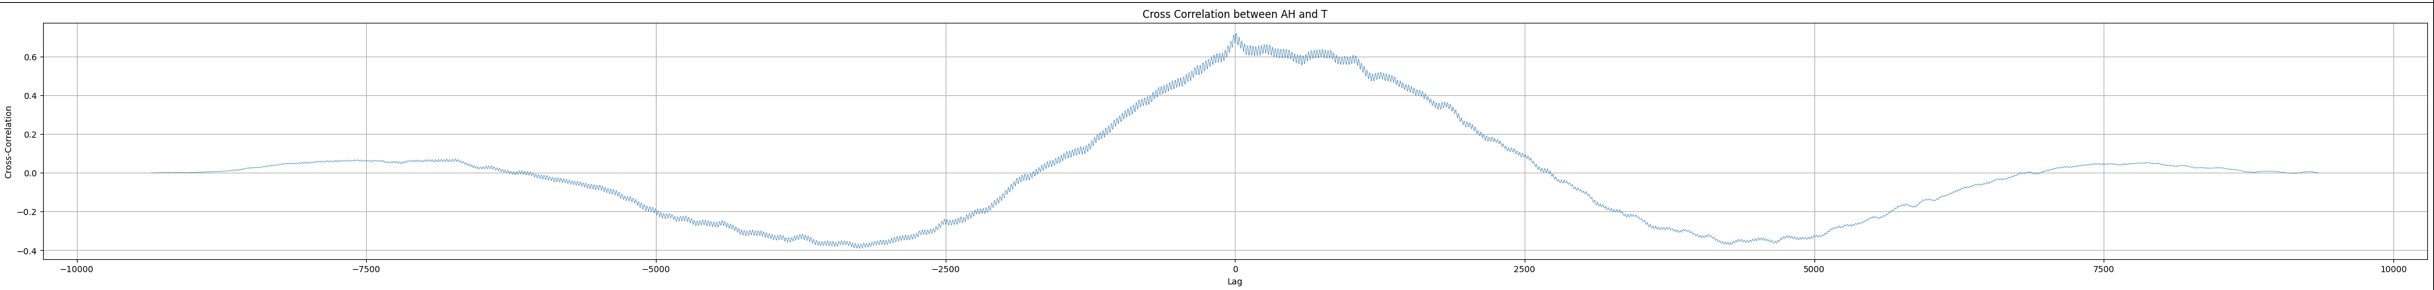

In graphs where this symmetry with respect to the x-axis is not observed, the relationship between the time series might not be reciprocal. This might mean that one variable acts as a cause and the other as an effect, or that there are different delays in their reciprocal effects.

Given the nature of the dataset, it is interesting to examine the accuracy of the sensor measurements by comparing them with reference values provided by a certified analyzer. It is expected that the time series of CO and PT08.S1, C6H6 and PT08.S5, NOx and PT08.S3, as well as NO2 and PT08.S4, will show the most significant cross-correlations, especially at lag 0, reflecting the effectiveness of the sensors in detecting levels of air pollution.

Concerning the analysis of the cross-correlation between benzene (C6H6) and sensor PT08.S5, as well as carbon monoxide (CO) and sensor PT08.S1, both pairs exhibit strong cross-correlations at zero lag 0 (approximately 0.8), indicating a close real-time relationship between sensor and gas concentration. This relationship fades as the time lags increase. Regular peaks also suggest a daily pattern affecting both measurements, possibly due to environmental cycles or human activities.

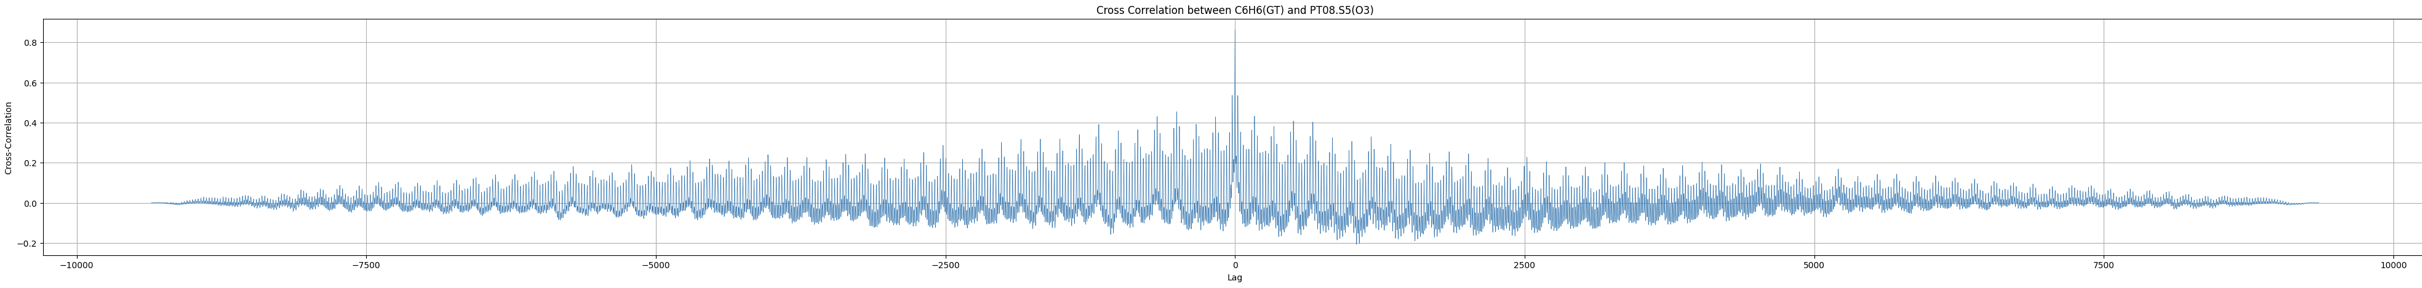

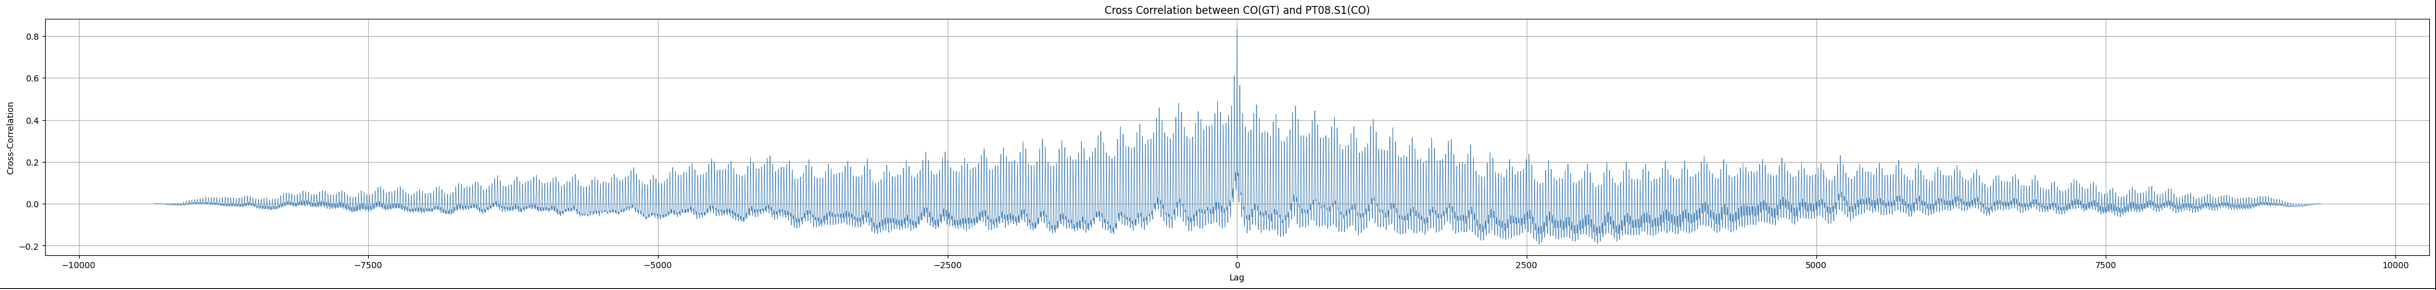

The graph of cross-correlation between nitrogen oxides (NOx) and PT08.S3 sensor shows a strong negative cross-correlation to zero lag, with values close to -0.6. Moving away from the zero lag, this negative cross-correlation weakens to zero, as in previous graphs.
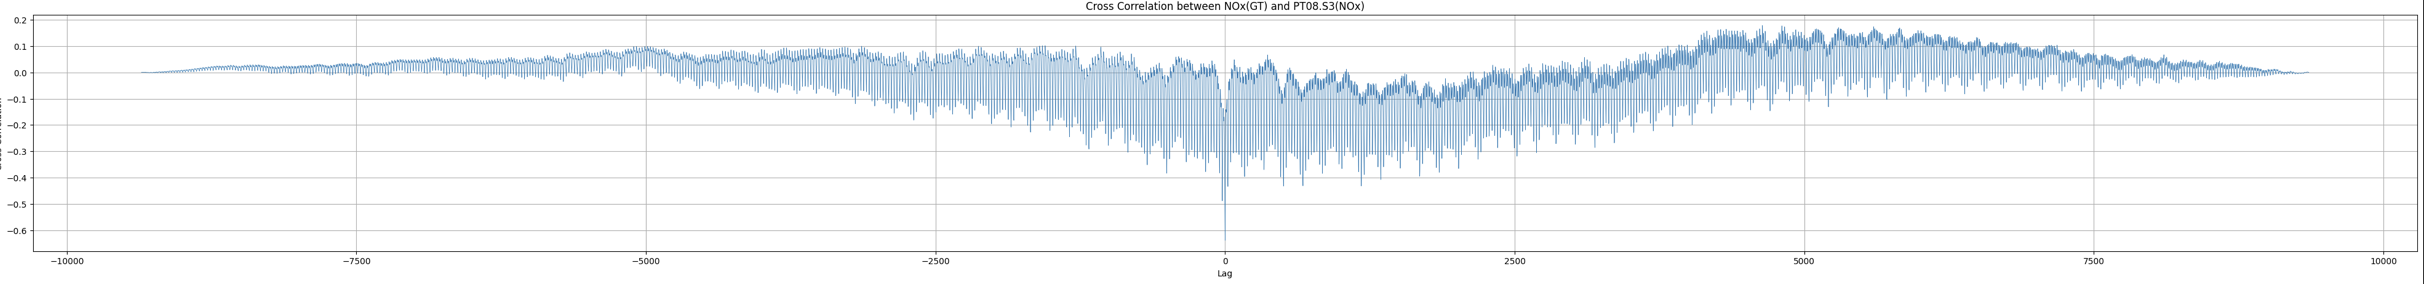



In the case of nitrogen dioxide (NO2) and PT08.S4, there does not appear to be a significant degree of linear cross-correlation between the two. In fact, the values in the graph range between -0.4 and 0.2, with the majority clustering around 0.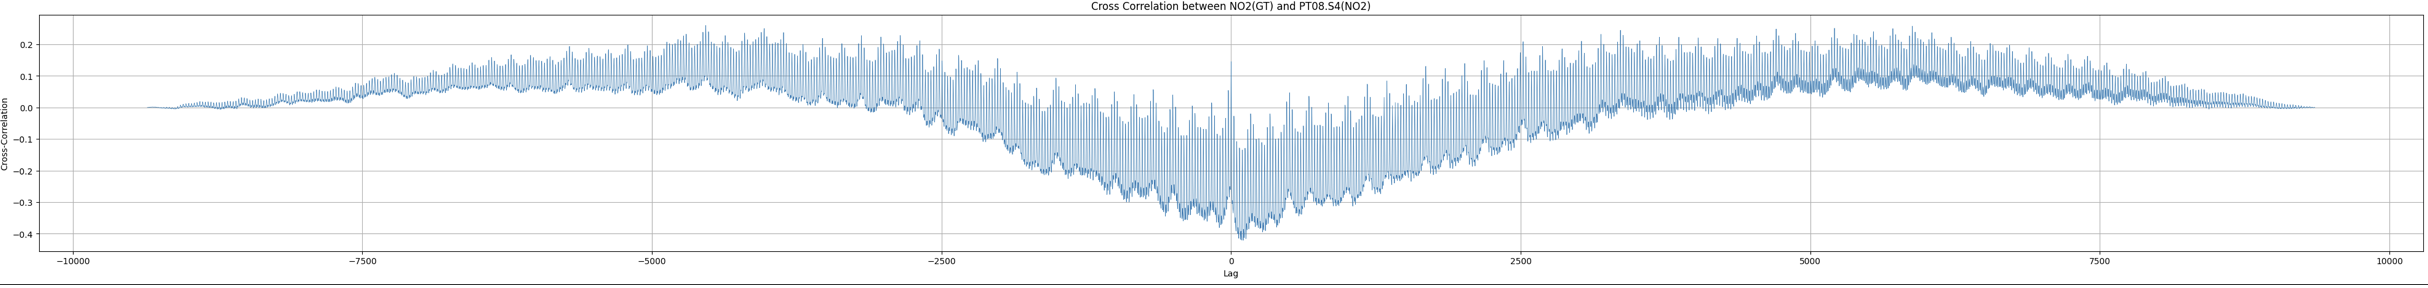

Upon examining the charts produced by the cross-correlation function, it was observed that most pairs of time series display a significant peak at lag 0. This implies a strong simultaneous cross-correlation among most of the series. To delve deeper into this behavior, a heatmap of the cross-correlation at lag 0 was created.

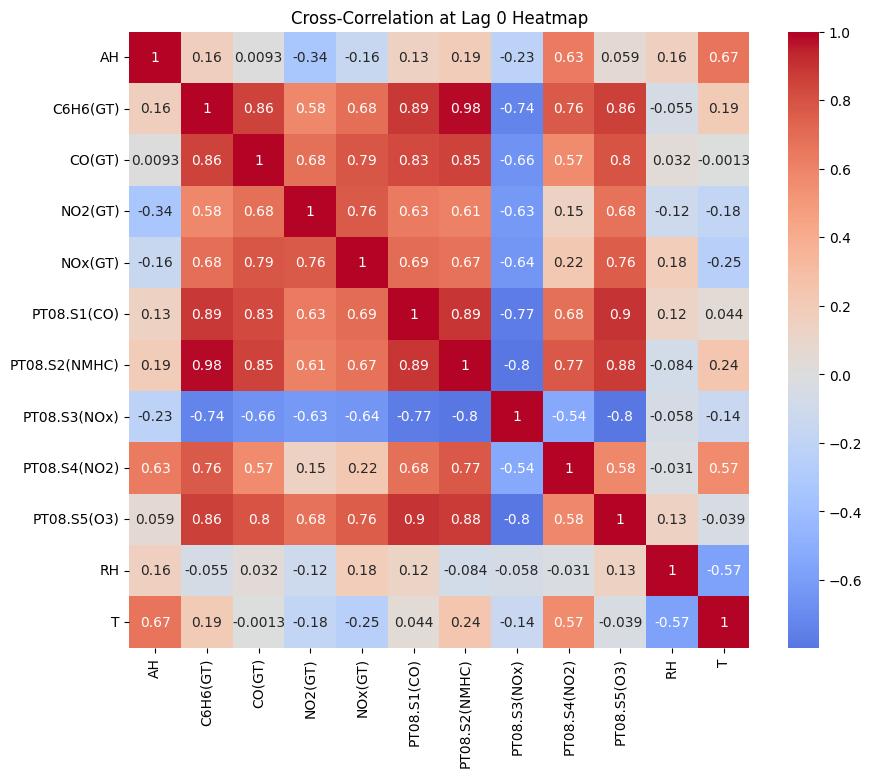

In [ ]:
plot_ccf_heatmap(ccf_matrix)

It is interesting to note that, although most sensors show a significant level of cross-correlation, there are some exceptions. Firstly, it appears that temperature, as well as both relative and absolute humidity, almost have no correlation with most of the sensors (apart from some exceptions, like the  cross-correlation between AH and T previously discussed, and the one between AH and PT08.S3). Moreover, the sensor PT08.S3 shows a strong negative cross-correlation with most of the other sensors. The deviation from the general trend may indicate a distinct response or sensitivity to certain compounds, which can distinguish it from the dynamics of other sensors.







**4. Conclusions**

Cross-correlation is certainly a valuable tool in time series analysis, but it is crucial to recognize its limitations.

A high cross-correlation observed between two time series does not necessarily imply a causal relationship. Two variables may be correlated because of a third factor influencing both, or they may simply move together by coincidence.

Moreover, cross-correlation measures linear relationships and might not capture more complex and nonlinear interactions. This means that there could be dynamics between the variables that a linear analysis fails to detect.

Therefore, if the data show a strong cross-correlation, this should be seen as a starting point for further investigation to reach more robust conclusions.